In [1]:
import numpy as np
import optiland.backend as be  # backend for numerical operations - either numpy or torch
from optiland.analysis.irradiance import IncoherentIrradiance
import torch
from Optical_environment.Optical_System.RL_Optical_Sys import OpticalSystem
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from Optical_environment.utils import compute_power, compute_irr_in_mask,spot_centroid_from_irr,compute_irr,\
get_detector_edges

d:\py\Anaconda3\envs\DiffOptics\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
d:\py\Anaconda3\envs\DiffOptics\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type ali

### Set backen to Torch
> Now all the function is developed based on torch, later I will add numpy method.

Don't run this if you don't use gradient base.

In [ ]:
# optional
be.set_backend("torch")  # all calculations will be done using torch
be.set_precision("float32")  # or "float64" for double precision
be.grad_mode.disable()  # enable gradient calculation. Can also be set to "disable" to save memory if gradients are not needed.
be.set_device("cpu")  # run on GPU if available, otherwise use "cpu" option

## Initialize Basic Optical System Parameters

In [10]:
# -------------------------------
# Basic Optical System Parameters
# -------------------------------
beam_size = 0.5                   # Beam diameter (mm)
wavelength = 0.78                 # Wavelength (μm or mm, depending on system units)
mirror_aperture = [12.7, 0.0]     # Mirror aperture [X, Y]
pinhole_aperture = [0.5, 0.0]     # Pinhole aperture [X, Y]
detector_aperture = [25.0, 25.0]  # Detector aperture [X, Y]

# -------------------------------
# Position Parameters (in system coordinates)
# -------------------------------

delta_x = np.random.uniform(-10, 10)   # X-offset of Mirror 2
delta_y = np.random.uniform(-10, 10)   # Y-offset correction of Mirror 2
delta_z = np.random.uniform(-10, 10)   # Z-offset correction of Mirror 2

mirror1_z = 100.0               # Z-position of Mirror 1
mirror2_base_y = -100.0         # Base Y-position of Mirror 2

mirror1_position = np.array([0.0, 0.0, mirror1_z])
mirror2_position = np.array([delta_x, mirror2_base_y + delta_y, 100.0+delta_z])

# -------------------------------
# Rotation Angles (in radians)
# -------------------------------

angle_range_deg = 2.4
angle_range = np.deg2rad(angle_range_deg)     # 弧度制范围

mirror_1_base_angle_deg = np.deg2rad(90+45)
mirror_2_base_angle_deg = np.deg2rad(-45)


rx1_rand = mirror_1_base_angle_deg + np.random.uniform(-angle_range, angle_range)
ry1_rand = np.random.uniform(-angle_range, angle_range)

rx2_rand = mirror_2_base_angle_deg + np.random.uniform(-angle_range, angle_range)
ry2_rand = np.random.uniform(-angle_range, angle_range)

rotation_angles_mirror1 = np.array([rx1_rand, ry1_rand, 0.0])  # Mirror 1 rotation (rad)
rotation_angles_mirror2 = np.array([rx2_rand, ry2_rand, 0.0])  # Mirror 2 rotation (rad)

# -------------------------------
# Optical Path Distance Parameters
# -------------------------------
delta_z1 = np.random.uniform(-20, 20)
delta_z2 = np.random.uniform(-20, 20)

m2_a1_dist = 70.0 + delta_z1                   # Distance: Mirror2 → Aperture1
a1_d1_dist = 20.0                              # Distance: Aperture1 → Detector1
a2_d2_dist = 20.0                              # Distance: Aperture2 → Detector2
aperture_dist = 150.0 + delta_z2 - 70.0 - delta_z1  # Distance between the two apertures


## Construct the Optical System Object

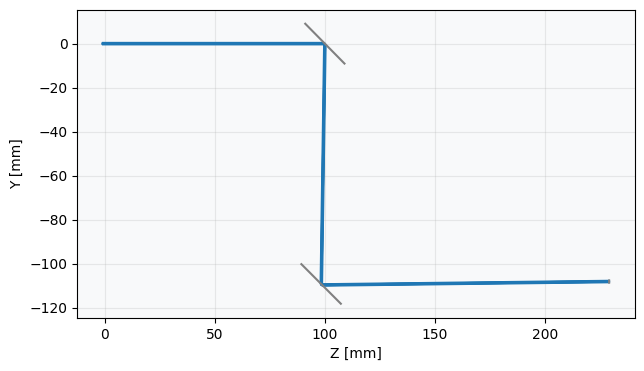

In [11]:
# -------------------------------
# Construct the Optical System Object
# -------------------------------
sys = OpticalSystem(
    beam_size = beam_size,
    wavelength = wavelength,
    mirror_aperture = mirror_aperture,
    pinhole_aperture = pinhole_aperture,
    detector_aperture = detector_aperture,
    mirror1_position = mirror1_position,
    mirror2_position = mirror2_position,
    rotation_angles_mirror1 = rotation_angles_mirror1,
    rotation_angles_mirror2 = rotation_angles_mirror2,
    aperture_dist = aperture_dist,
    m2_a1_dist = m2_a1_dist,
)

# -------------------------------
# Validation and Visualization
# -------------------------------
if not sys.is_valid:
    print("Invalid Optical System!")
else:
    sys.draw(num_rays=5, reference="chief", distribution="uniform")


In [27]:
sys.draw3D(num_rays=5, reference="chief", distribution="uniform")

### Sys Infomation

In [21]:
sys.info()

╒════╤═══════════════╤═══════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type          │ Comment   │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═══════════════╪═══════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar        │ Light     │      inf │    inf      │ Air        │       0 │             0.5 │
│  1 │ Planar        │ Aperture  │      inf │    100      │ Air        │       0 │             0.5 │
│  2 │ Planar        │ Mirror1   │      inf │    -98.5862 │ Mirror     │       0 │            12.7 │
│  3 │ Planar        │ detector  │      inf │      0      │ Air        │       0 │             0.5 │
│  4 │ Planar        │ Mirror2   │      inf │     81.6907 │ Mirror     │       0 │            12.7 │
│  5 │ Planar        │ Detector  │      inf │      0      │ Air        │       0 │             0.5 │
│  6 │ Planar        │ Aperture1 │      inf │      0      │ glass      │       0 │         

### Beam spot on detector with Pinhole mask

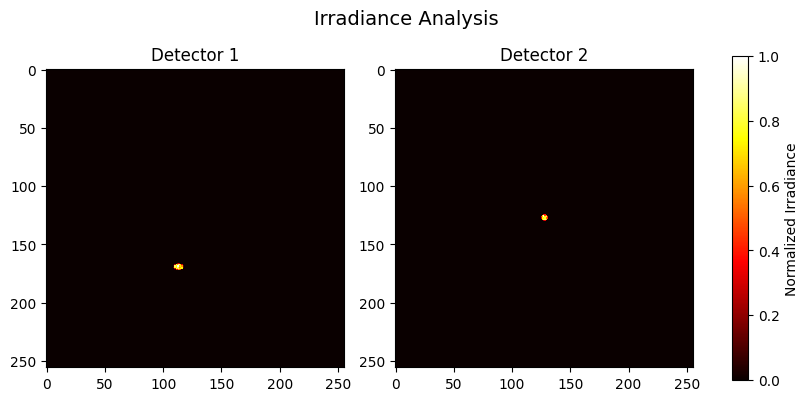

In [6]:
# ------------------------------
# 1) Get irradiance maps
# ------------------------------
"""
Look up the surface number in the Sys Info .
╒════╤═══════════════╤═══════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type          │ Comment   │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═══════════════╪═══════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar        │ Light     │      inf │    inf      │ Air        │       0 │             0.5 │
│  1 │ Planar        │ Aperture  │      inf │    100      │ Air        │       0 │             0.5 │
│  2 │ Planar        │ Mirror1   │      inf │    -90.1899 │ Mirror     │       0 │            12.7 │
│  3 │ Planar        │ detector  │      inf │      0      │ Air        │       0 │             0.5 │
│  4 │ Planar        │ Mirror2   │      inf │     81.422  │ Mirror     │       0 │            12.7 │
│  5 │ Planar        │ Detector  │      inf │      0      │ Air        │       0 │             0.5 │
│  6 │ Planar        │ Aperture1 │      inf │      0      │ glass      │       0 │             0.5 │
│  7 │ Planar        │ Aperture1 │      inf │     85.2438 │ Air        │       0 │             0.5 │
│  8 │ Planar        │ Detector  │      inf │      0      │ Air        │       0 │             0.5 │
│  9 │ Planar        │ Aperture2 │      inf │      0      │ glass      │       0 │             0.5 │
│ 10 │ Stop - Planar │ Aperture2 │      inf │    nan      │ Air        │       0 │             0.5 │
╘════╧═══════════════╧═══════════╧══════════╧═════════════╧════════════╧═════════╧═════════════════╛
"""
irr_map1 = compute_irr(sys, detector_surface=3, num_rays=1000) 
irr_map2, _ = compute_irr_in_mask(sys, detector_surface=5, num_rays=1000,radius=beam_size)

# Convert to NumPy arrays
irr_map1_numpy = irr_map1.detach().cpu().numpy()
irr_map2_numpy = irr_map2.detach().cpu().numpy()

vmin, vmax = 0, 1
norm = Normalize(vmin=vmin, vmax=vmax)

plt.figure(figsize=(8, 4), constrained_layout=True)

plt.subplot(1, 2, 1)
im = plt.imshow(irr_map1_numpy, cmap="hot", norm=norm, interpolation="nearest")
plt.title("Detector 1")

plt.subplot(1, 2, 2)
plt.imshow(irr_map2_numpy, cmap="hot", norm=norm, interpolation="nearest")
plt.title("Detector 2")

fig = plt.gcf()
cbar = fig.colorbar(im, ax=fig.axes, orientation="vertical", shrink=0.9)
cbar.set_label("Normalized Irradiance")

plt.suptitle("Irradiance Analysis", fontsize=14)

plt.show()


### Compute Power on the detector with pinhole mask

In [7]:
compute_power(sys,5,num_rays=1000,radius=beam_size)

tensor(959.0001)

In [26]:
irr = compute_irr(sys,3)
x_edges, y_edges = get_detector_edges(detector_aperture, res=(256,256))
print(spot_centroid_from_irr(irr,x_edges,y_edges))

(tensor(3.6157), tensor(-7.4561), tensor(21.8442))


### Set angle

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Z [mm]', ylabel='Y [mm]'>)

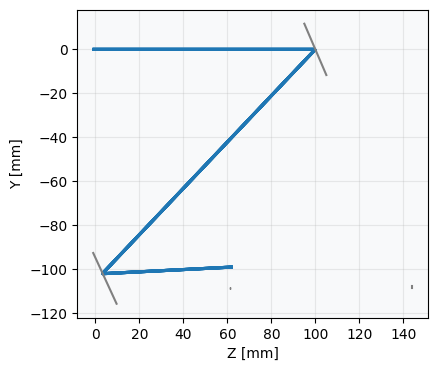

In [14]:
a = np.deg2rad(rx1_rand+1.3)
b = np.deg2rad(ry1_rand-1.1)
c = np.deg2rad(rx2_rand+0.1)
d= np.deg2rad(ry2_rand+0.1)
sys.set_mirror_angle(rx1=a, ry1=b, rx2=c, ry2=d, gradient=False)
sys.draw(num_rays=10,reference="chief",distribution="uniform")
